## Load In Libraries

In [1]:
import math
import ctREFPROP.ctREFPROP as ct
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Hack for my installation
os.environ['RPPREFIX'] = r'C:\\Program Files (x86)\REFPROP'

root = os.environ['RPPREFIX']
#r = ct.REFPROPFunctionLibrary(os.path.join(root, 'refprop.dll'))
r = ct.REFPROPFunctionLibrary(os.path.join(root, 'REFPRP64.dll'))
r.SETPATHdll(root)

## Real Gas Data Generation

In [2]:
fuel_type = 'ethane.FLD'
amb_type='nitrogen.FLD'

## Conditions
Pchamb = 5000
Pinj= Pchamb#013700##########make Pinj=Pchamb for isothermal assumption
TfuelIn = np.array([250,305.33,308,350,400,450])
Tamb = 400

## Construct fluid mixture
mix_list=fuel_type+"|"+amb_type
ierr, herr = r.GERG08dll(2,0)
if ierr !=0:
    raise ValueError(str(ierr) + ':' + herr)

r.FLAGSdll('GERG',1)
ierr, herr = r.SETUPdll(2,mix_list,'HMX.BNC','DEF')

if ierr !=0:
    raise ValueError(str(ierr) + ':' + herr)
zf=[1,0]
zamb=[0,1]


    
## Initialize
dX = 0.01
xf = np.arange(0,1+dX,dX)
yf = np.zeros(xf.size)
rhomix = np.zeros(xf.size)
Tmix = np.zeros((xf.size,TfuelIn.size))
Rmix = np.zeros(xf.size)
nmix = np.zeros(xf.size)
delmix = np.zeros(xf.size)
phi = np.zeros(xf.size)
MW_mix = np.zeros(xf.size)
T_sat_V = np.zeros(xf.size)
T_sat_L = np.zeros(xf.size)
## Sat values
i=-1
for x in xf:
    i+=1
    z=[x,(1-x)]
    satprops = r.SATPdll(Pchamb,z,2)
    T_sat_V[i] = satprops.T
    satprops = r.SATPdll(Pchamb,z,1)
    T_sat_L[i] = satprops.T

jj=-1
total_steps = TfuelIn.size
for T in TfuelIn:
    jj+=1
    fInlet = r.TPFLSHdll(T,Pinj,zf)
    Amb = r.TPFLSHdll(Tamb,Pchamb,zamb)
    HfInlet = fInlet.h
    HAmb = Amb.h
 
    i=-1
    for x in xf:
        i+=1
        hmix = HfInlet*x+HAmb*(1-x)
        z=[x,(1-x)]
        MW_mix[i] = r.WMOLdll(z)
        Props = r.PHFLSHdll(Pchamb,hmix,z)
        rhomix[i] = Props.D*MW_mix[i]
        Tmix[i,jj] = Props.T
        if Props.ierr!=0:
            Tmix[i,jj] = None
    print('%d / %d'%(jj+1, total_steps),end='\r')

In [3]:
i=-1
for T in T_sat_V:
    i+=1
    if T_sat_V[i]>350:
        T_sat_V[i]=None
    if T_sat_L[i]>350:
        T_sat_L[i]=None 
T_sat_L[0:50]=None


a = pd.Series(T_sat_V)
i=-1
while i<1:
    i+=1
    aint = a.interpolate(method="polynomial", order=3)
    T_sat_V2 = aint.to_numpy()
np.count_nonzero(np.isnan(T_sat_V2))

a = pd.Series(T_sat_L)
i=-1
while i<1:
    i+=1
    aint = a.interpolate(method="polynomial", order=3)
    T_sat_L2 = aint.to_numpy()
np.count_nonzero(np.isnan(T_sat_L2))


Tmix3 = np.zeros((xf.size,TfuelIn.size))
Tmix2 = np.zeros((xf.size,TfuelIn.size))
jj=-1
for Tsweep in TfuelIn:
    jj+=1
    TsingleMix = Tmix[:,jj]
    a = pd.Series(TsingleMix)
    i=-1
    while i<1:
        i+=1
        aint = a.interpolate(method="polynomial", order=3)
        Tmix2[:,jj] = aint.to_numpy()

    i=-1
    for T in T_sat_V2:
        i+=1
        if Tmix2[i,jj]<T:
            Tmix3[i,jj]=None
        else:
            Tmix3[i,jj]=Tmix2[i,jj]

## Tmix Plot

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


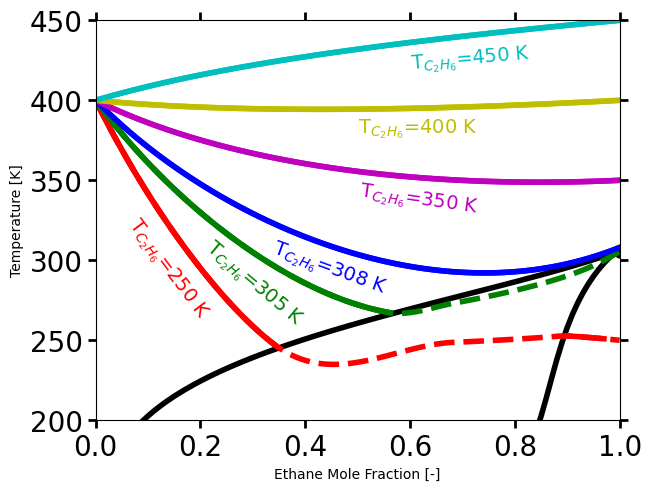

In [4]:
import matplotlib as mpl

SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

fig, ax = plt.subplots(constrained_layout=True)
#HSV= plt.get_cmap('cool')
#colors = iter(HSV(np.linspace(0,1,TfuelIn.size)))
colors = ['r','g','b','m','y','c']
jj=-1
for T in TfuelIn:
    jj+=1
    #color=next(colors)
    color = colors[jj]
    plt.plot(xf,Tmix3[:,jj],color,linewidth=4)
plt.plot(xf,T_sat_V2,'k',linewidth=4)
plt.plot(xf,T_sat_L2,'k',linewidth=4)
plt.plot(xf[90:100],Tmix[90:100,0],'r',linewidth=4)
plt.plot(xf[-1],T_sat_V2[-1],'ko',markersize=8)
jj=-1
for T in TfuelIn:
    jj+=1
    color=colors[jj]
    if jj==0:
        plt.plot(xf,Tmix2[:,jj],'r--',linewidth=4)
    if jj==1:
        plt.plot(xf,Tmix2[:,jj],'g--',linewidth=4)
    plt.plot(xf,Tmix3[:,jj],color,linewidth=4)
    
plt.xticks(fontsize=BIGGER_SIZE)
plt.yticks(fontsize=BIGGER_SIZE)
plt.xlabel('Ethane Mole Fraction [-]')
plt.ylabel('Temperature [K]')
#plt.legend(['Boiling Line','Cricondentherm'])
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
font = {'family' : 'normal',
        'weight' : 'normal'}
ax.tick_params(direction='out', length=6, width=2, colors='k',
               grid_color='r', grid_alpha=0.5,right='bool',top='bool')
plt.rc('font', **font)
#plt.legend(['$T_{mix}$','Sat. Lines'],fontsize=MEDIUM_SIZE,frameon=False,loc='upper center')
#plt.text(0.4,240,'Vapor-Liquid Equilbruim',fontsize=SMALL_SIZE, color='k')
#plt.text(0.55,233,'Region',fontsize=SMALL_SIZE, color='k')
#plt.text(0.96,293,'Critical',fontsize=SMALL_SIZE, color='k')
#plt.text(0.2,287,'Point',fontsize=SMALL_SIZE, color='k')
plt.text(0.05,265,'T$_{C_2H_6}$=250 K',fontsize=14, color='r',rotation=-53)
plt.text(0.2,260,'T$_{C_2H_6}$=305 K',fontsize=14, color='g',rotation=-40)
plt.text(0.33,280,'T$_{C_2H_6}$=308 K',fontsize=14, color='b',rotation=-20)
plt.text(0.5,330,'T$_{C_2H_6}$=350 K',fontsize=14, color='m',rotation=-8)
plt.text(0.5,380,'T$_{C_2H_6}$=400 K',fontsize=14, color='y',rotation=0)
plt.text(0.6,420,'T$_{C_2H_6}$=450 K',fontsize=14, color='c',rotation=5)
ax.set_yticks(np.linspace(200, 450, 6))
plt.ylim([200, 450])
plt.xlim([0, 1])
plt.show()

